In [270]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import networkx as nx
import pandas as pd

,f,t,cap,L,ftime,b,power,speed,toll,link_type,;
0,1,547,49500,0.86267,0.00,0.15,4,0,0,3,;
1,2,548,49500,0.86267,0.00,0.15,4,0,0,3,;
2,3,549,49500,0.86267,0.00,0.15,4,0,0,3,;
3,4,550,49500,0.86267,0.00,0.15,4,0,0,3,;
4,5,551,49500,0.86267,0.00,0.15,4,0,0,3,;
...,...,...,...,...,...,...,...,...,...,...,...
2945,931,906,500,22.65430,14.78,0.15,4,0,0,1,;
2946,932,386,49500,0.86267,0.00,0.15,4,0,0,3,;
2947,932,515,5000,10.44260,5.93,0.15,4,0,0,2,;
2948,933,387,49500,0.86267,0.00,0.15,4,0,0,3,;


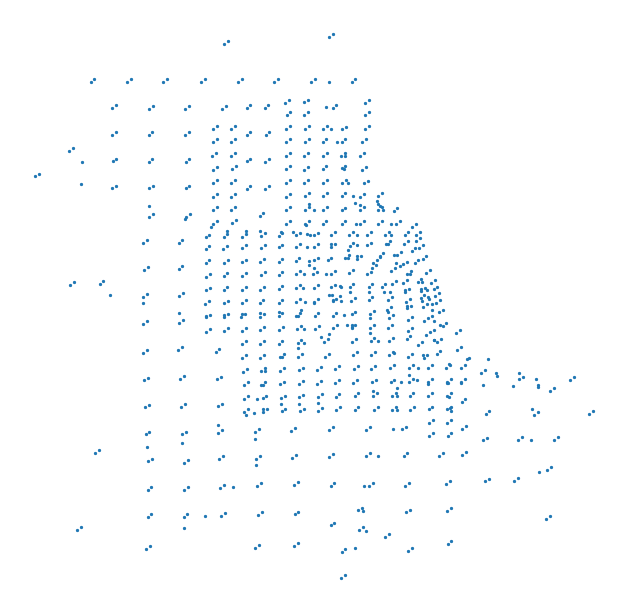

In [271]:
df = pd.read_csv('node.csv')
df
plt.figure(figsize=(11,11))
plt.scatter(df['X'],df['Y'],s=5)

plt.axis('off')
plt.savefig('base'+  ' .png', format='png', dpi=200)


df
net = pd.read_csv('net.csv')
net


In [274]:
G = nx.Graph()
population = {}

for n in df['node']:
    population[n] = 50*random.randint(10,200)
connect = {}
dist = {}

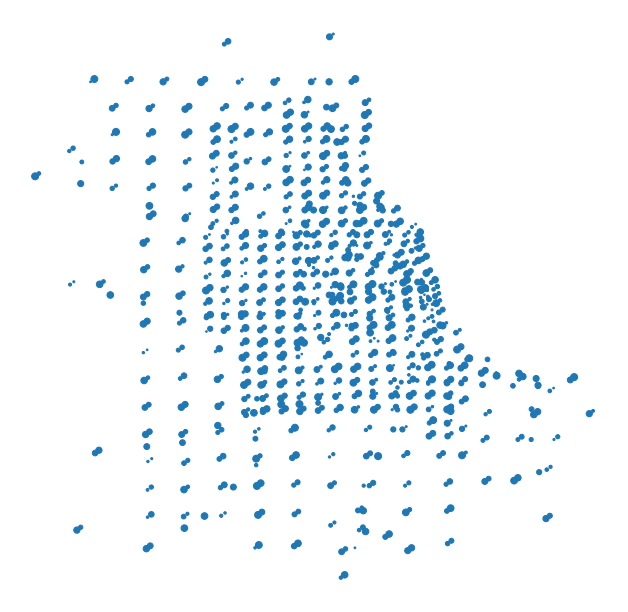

In [275]:
df['pop'] = [population[n] for n in population]
df['pop']= 50*df['pop']/df['pop'].max()
df

plt.figure(figsize=(11,11))
plt.scatter(df['X'],df['Y'],s=df['pop'])

plt.axis('off')
plt.savefig('base pop'+  ' .png', format='png', dpi=200)





In [276]:
for r in range(len(net)):
    f = int(net.loc[r,'f'])
    t = int(net.loc[r,'t'])
    L = net.loc[r,'L']
    connect[f,t]=L
    connect[t,f]=L
    xf= df.loc[f-1,'X']
    yf= df.loc[f-1,'Y']
    xt= df.loc[t-1,'X']
    yt= df.loc[t-1,'Y']
    #L= np.sqrt( (xf-xt)**2+ (yf-yt)**2)/1000
    G.add_edge(f, t, weight=L)
    #print((f,t), L)
N = df['node'].max()
for f in range(1,N+1):
    for t in range(1,N+1):
        if f>t:
            if (f,t) in connect:
                dist[f,t], dist[t,f] = L , L 
            else:
                dist[f,t] = nx.shortest_path_length(G, source=f, target=t , weight='weight')
                dist[t,f] = dist[f,t]

S = dist.values()
min(S),max(S)

(1.03769, 170.34336999999994)

In [277]:
min(S),max(S)
#len(dist)
dist[1,574]

15.162609999999999

In [303]:
N = df['node'].max()
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize=model.i)
model.select = Var(model.i, initialize=0, within=Binary)
model.reach = Var(model.i, initialize=0, within=Binary)

target1 = 60 
target2 = 20
Ncar = 10
Nreq = 1
def rule_C1(model,i):
    return model.select[i] + sum(model.select[j] for j in model.j if j!=i and dist[i,j]<=target1) >= 1
model.C1 = Constraint(model.i, rule=rule_C1)
    
def rule_C2(model,i):
    return model.select[i] + sum(model.select[j] for j in model.j if j!=i and dist[i,j]<=target2) >= Nreq*model.reach[i]        
model.C2 = Constraint(model.i, rule=rule_C2)
     
def rule_C2A(model,i):
    return model.select[i] + sum(model.select[j] for j in model.j if j!=i and dist[i,j]<=target2)-1 <= Ncar*model.reach[i]        
#model.C2A = Constraint(model.i, rule=rule_C2A)
     
def rule_C4(model):
    return sum(model.select[i] for i in model.i) <= Ncar 
model.C4 = Constraint(rule=rule_C4)
      
def rule_OF(model):
    return (1e-5)*sum(model.reach[i]*population[i] for i in model.i)
model.obj = Objective(rule= rule_OF, sense=maximize)

opt = SolverFactory('cbc')
instance = model.create_instance()

results = opt.solve(instance, options={"threads": 4,"ratio": 0.1}) # solves and updates instance
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)  
print(value(instance.obj))

feasible
48.537000000000006


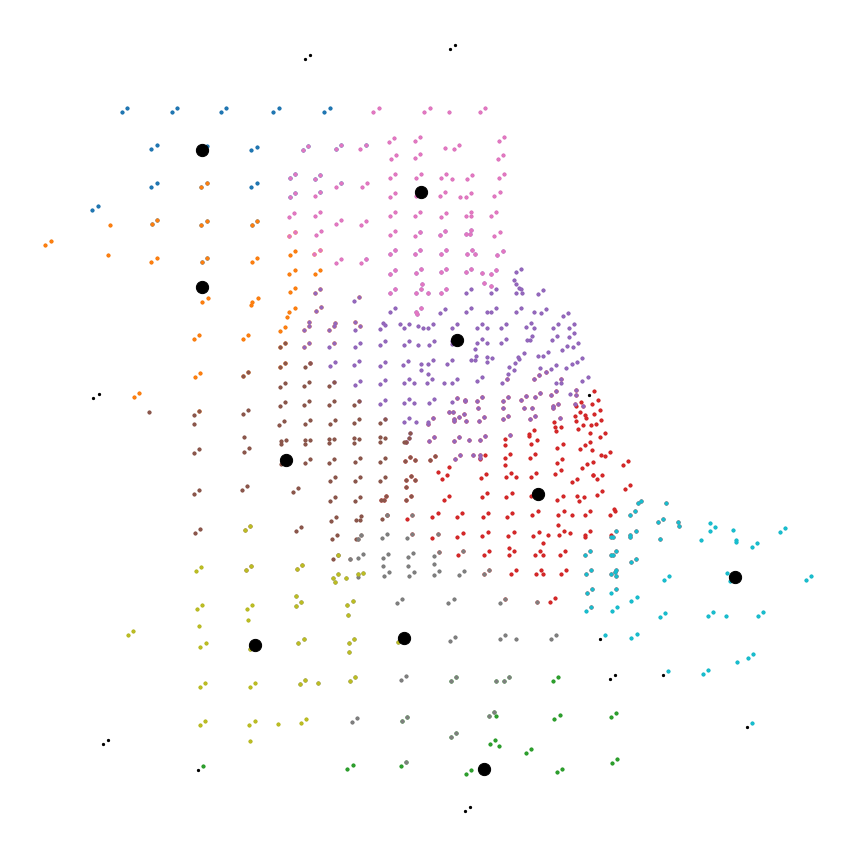

In [304]:
KOLOR=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
Nc = len(KOLOR)
plt.figure(figsize=(12,12))
counter = 0 
for i in instance.i:
    x1= df.loc[i-1,'X']
    y1= df.loc[i-1,'Y']
    
    if value(instance.select[i])>0:
        counter = counter%Nc
        plt.scatter(x1,y1,s=150, c='k',alpha=1, zorder= 2)
        cover = [j for j in instance.j if i!=j and dist[i,j]<target2]
        X=[df.loc[j-1,'X'] for j in cover ]
        Y=[df.loc[j-1,'Y'] for j in cover ]
        
        plt.scatter(X,Y,s=10, c=KOLOR[counter], zorder= 1)
        counter+=1
plt.scatter(df['X'],df['Y'],s=5, c='k', zorder = -1)

plt.axis('off')
plt.tight_layout()
plt.savefig('final cover 1'+  ' .png', format='png', dpi=200)


537
557
657
723
737
750
758
824
854
856


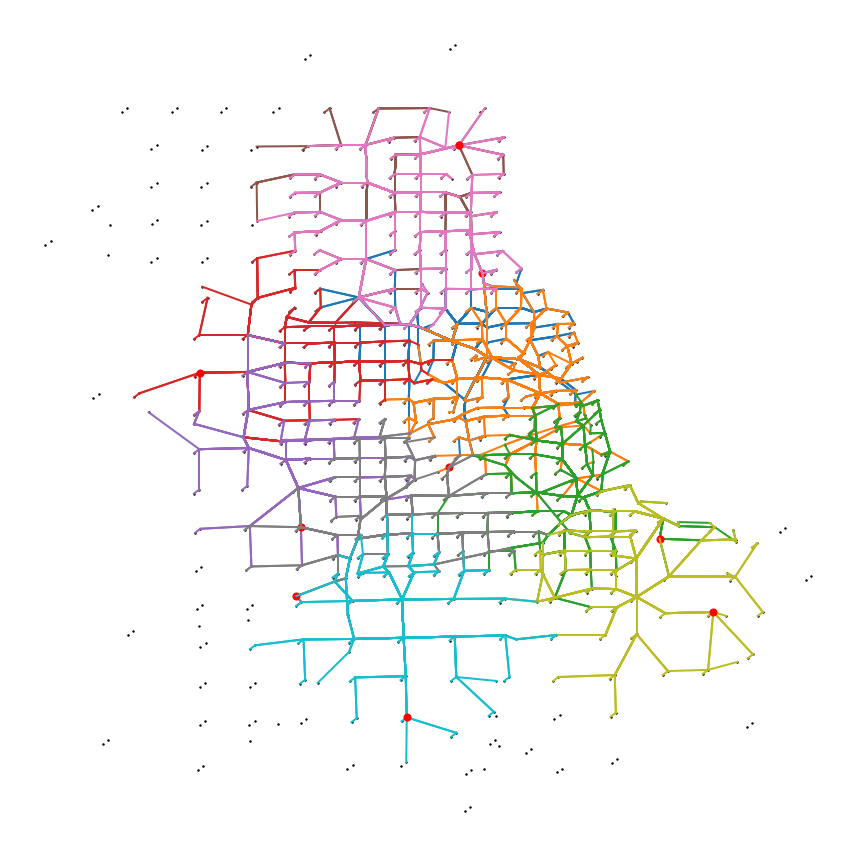

In [299]:
KOLOR=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(12,12))
plt.scatter(df['X'],df['Y'],s=2, c='k')
counter = 0 
for i in instance.i:
    x1= df.loc[i-1,'X']
    y1= df.loc[i-1,'Y']
    
    if value(instance.select[i])>0:
        cover = [j for j in instance.j if i!=j and dist[i,j]<target2]
        X=[df.loc[j-1,'X'] for j in cover ]
        Y=[df.loc[j-1,'Y'] for j in cover ]
        print(i)
        
        for j in cover:
            path = nx.shortest_path(G, source=i, target=j)
            for c in range(len(path)-1):
                p1 = path[c]
                p2 = path[c+1]
                x1= df.loc[p1-1,'X']
                y1= df.loc[p1-1,'Y']
                x2= df.loc[p2-1,'X']
                y2= df.loc[p2-1,'Y']
                plt.plot([x1,x2],[y1,y2],c=KOLOR[counter], lw=2)   
            
                
        #plt.scatter(X,Y,s=10, c=KOLOR[counter], zorder= 2)
        
        plt.scatter(x1,y1,s=50, c='r', zorder= 2)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('gradual cover'+ str(counter)+  ' .png', format='png', dpi=200)

        counter+=1
        counter = counter%Nc

